# Double Pendulum Analysis Using NG‑RC with Additional Parameters 

This notebook analyzes a double pendulum system using the Next Generation Reservoir Computing (NG‑RC) framework while considering additional model parameters (e.g. L1 and M1). 

In this notebook:
- We simulate the double pendulum dynamics using an ODE solver.
- We prepare the data and construct feature vectors, including extra model parameters.
- We train the NG‑RC model with these extra parameters via ridge regression.
- We generate predictions for training and testing phases.
- We visualize the results with time series, scatter and phht charts.
- We compute performance metrics (RMSE, MAE, R2, etc.) to evaluate prediction accuracy.

All required modules are imported from the `src` directory.


In [1]:
import sys
import os

# Add the project root to the system path so that modules in 'src' can be imported
sys.path.append(os.path.abspath('..'))

# Import required modules from the src folder
from src.models.double_pendulum import DoublePendulum
from src.ngrc.ngrc_model import (
    ModelParameters, 
    DatasetDiscretization, 
    FeatureVector, 
    compute_training_prediction, 
    compute_testing_prediction, 
    calculate_metrics, 
    compute_testing_prediction_with_params
)
from src.utils.solver import simulate_dynamic_system
from src.utils.plot_helper import (
    plot_comparison, 
    plot_comparison_only_testing, 
    plot_scatter_comparison, 
    plot_phase_comparison, 
    plot_scatter_comparison_only_testing, 
    plot_phase_comparison_only_testing, 
    plot_W_out, 
    get_feature_labels
)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

# Update matplotlib parameters for consistent styling
plt.rcParams.update({
    'font.size': 10,
    'lines.linewidth': 0.8,
    'figure.dpi': 300,
    'axes.grid': True,
})


## Simulation and Parameter Setup

In the following cell, we define the simulation parameters and initial conditions for the double pendulum, as well as the physical parameters of the system. Additionally, we specify arrays of possible values for extra parameters (L1 and M1) and generate all combinations of these values. Finally, we retrieve the ODE solver function for the double pendulum from the `DoublePendulum` class.


In [3]:
# Simulation parameters
dt = 0.01                               # Time step (seconds)
max_time = 100                          # Total simulation time (seconds)
t_eval = np.linspace(0, max_time, round(max_time / dt) + 1)

# Initial conditions for the pendulum (angles in degrees, converted to radians)
theta1, omega1 = 60.0, 0.0
theta2, omega2 = 30.0, 0.0
initial_state = np.radians([theta1, omega1, theta2, omega2])

# Pendulum parameters
G = 9.8       # Gravitational acceleration (m/s^2)
L2 = 1        # Length of second pendulum (m)
M2 = 1        # Mass of second pendulum (kg)

# Extra parameter arrays for the first pendulum
L1_array = [0.5, 1, 1.5, 2]   # Possible lengths for the first pendulum
M1_array = [0.5, 1, 1.5, 2]   # Possible masses for the first pendulum

# Generate all combinations of L1 and M1 values
L1_M1_array = list(itertools.product(L1_array, M1_array))

# Get the double pendulum solver method from the DoublePendulum class
double_pendulum_solver = DoublePendulum.double_pendulum_solve_ivp


## Training Considering Various Initial Conditions

In this cell, the NG‑RC model is trained under different initial conditions by iterating over all combinations of the extra parameters L1 and M1. The process is as follows:

- **For each (L1, M1) combination:**
  - Set the corresponding parameters and simulate the double pendulum dynamics using the ODE solver.
  - Configure the NG‑RC model parameters and create the dataset discretization object.
  - Build the linear feature vector from the simulation data.
  - Construct the full feature vector, including polynomial features.
  - Append the extra parameters (L1 and M1) as additional rows to the full feature vector.
  - Compute the difference solution (i.e., the difference between consecutive values in the first part of the feature vector).
  - Store the processed feature vectors and difference solution in a dictionary.

- **After the loop:**
  - Concatenate all the difference solutions and full feature vectors (with extra parameters) along the column axis.
  - Calculate the output weight matrix (W_out) using the ridge regression formula with a regularization term.

This procedure allows training the NG‑RC model by incorporating the extra parameters (L1 and M1) into the feature vectors.


In [30]:
# NG‑RC Configuration Parameters
polynomial_order = 2
input_dimension = 4
delay_taps = 2
include_constant = False
ridge_regression = 1.0e-3
including_all_pol_combination = True

# Training and Testing Percentages (100% training, 0% testing)
train_percentage = 100
test_percentage = 0

# Dictionary to store solutions for each set of extra parameters (L1, M1)
solutions_dict = {}
count_solutions = 0

# Loop over all combinations of extra parameters (L1, M1)
for L1_M1 in L1_M1_array:
    L1 = L1_M1[0]
    M1 = L1_M1[1]

    # Define simulation parameters tuple for the double pendulum: (L1, L2, M1, M2, G)
    params = (L1, L2, M1, M2, G)
    
    # Simulate the double pendulum dynamics using the solver method
    pendulum_states, time_array = simulate_dynamic_system(
        double_pendulum_solver, initial_state, params, dt, max_time
    )
    
    # --------------------- NG‑RC CONFIGURATION ---------------------
    # Create NG‑RC model parameters
    model_params = ModelParameters(
        polynomial_order=polynomial_order,
        input_dimension=input_dimension,
        delay_taps=delay_taps,
        include_constant=include_constant,
        ridge_regression=ridge_regression
    )
    
    # Create dataset discretization object (80% training, 20% testing)
    dataset_disc = DatasetDiscretization(
        model_params, time_array, train_percentage=train_percentage, test_percentage=test_percentage
    )
    
    # Build the feature vector object for NG‑RC training (including all polynomial combinations)
    feature_vec_obj = FeatureVector(
        model_params, pendulum_states, dataset_disc,
        including_all_pol_combination=including_all_pol_combination
    )

    # Extract discretization indices and related parameters
    warmup = dataset_disc.warmup_pts()
    warmup_train = dataset_disc.warmup_train_pts()
    train_pts = dataset_disc.train_pts()
    test_pts = dataset_disc.test_pts()
    input_dim = model_params.input_dimension
    ridge_param = model_params.ridge_regression
    
    # Build the linear feature vector from the simulation data
    linear_vector = feature_vec_obj.build_linear_feature_vector()
    
    # Compute the difference between consecutive values (for the first input_dim rows)
    diff_solution = linear_vector[0:input_dim, warmup:warmup_train] - \
                    linear_vector[0:input_dim, warmup - 1:warmup_train - 1]
    
    # Build the full feature vector
    full_vector = feature_vec_obj.build_full_feature_vector(linear_vector)
    dtot = full_vector.shape[0]
    dtot_with_params = dtot + 2  # Additional 2 rows for extra parameters L1 and M1

    # Append extra parameters as new rows in the feature vector
    _, num_columns = full_vector.shape
    new_rows = np.array([[L1] * num_columns, [M1] * num_columns])
    full_feature_vec_with_params = np.vstack((full_vector, new_rows))

    # Store the processed feature vectors and difference solution in a dictionary
    solution_dict = {
        'full_feature_vec_with_params': full_feature_vec_with_params,
        'diff_sol_values': diff_solution
    }
    solutions_dict[count_solutions] = solution_dict
    count_solutions += 1

# Concatenate difference solution values from all parameter combinations along columns
tuple_diff_sol_values = tuple(sol['diff_sol_values'] for sol in solutions_dict.values())
concat_diff_sol_values = np.concatenate(tuple_diff_sol_values, axis=1)

# Concatenate full feature vectors (with extra parameters) from all parameter combinations along columns
tuple_full_feature_vec = tuple(sol['full_feature_vec_with_params'] for sol in solutions_dict.values())
concat_full_feature_vec = np.concatenate(tuple_full_feature_vec, axis=1)

# Compute the output weights (W_out) using ridge regression
W_out = concat_diff_sol_values @ concat_full_feature_vec.T @ np.linalg.pinv(
    concat_full_feature_vec @ concat_full_feature_vec.T + ridge_param * np.identity(dtot_with_params)
)

KeyboardInterrupt: 

## NG‑RC Prediction on a New Configuration

After training the NG‑RC model with various initial conditions, we now simulate the double pendulum using a configuration that was not part of the training dataset. In the following cell, we:

- Define new physical parameters and initial conditions for the pendulum.
- Simulate the pendulum dynamics using the ODE solver.
- Configure the NG‑RC prediction setup (with 0% training and 100% testing).
- Build the necessary feature vectors.
- Generate predictions using the trained NG‑RC model.
subsequent processing.


In [ ]:
# --------------------- NG‑RC PREDICTION CONFIGURATION ---------------------

# Double pendulum parameters for prediction
G = 9.8             # Gravitational acceleration (m/s²)
L1 = 1.2            # Length of the first pendulum (m)
L2 = 1              # Length of the second pendulum (m)
M1 = 0.4            # Mass of the first pendulum (kg)
M2 = 1              # Mass of the second pendulum (kg)
params = (L1, L2, M1, M2, G)

# Simulate the double pendulum dynamics and obtain the time array
pendulum_states, time_array = simulate_dynamic_system(
    double_pendulum_solver, 
    initial_state, 
    params, 
    dt, 
    max_time
)

# --------------------- NG‑RC CONFIGURATION ---------------------
# Create NG‑RC model parameters
model_params = ModelParameters(
    polynomial_order=polynomial_order,
    input_dimension=input_dimension,
    delay_taps=delay_taps,
    include_constant=include_constant,
    ridge_regression=ridge_regression
)

# Discretize the dataset for prediction (0% training, 100% testing)
dataset_disc = DatasetDiscretization(
    model_params, 
    time_array, 
    train_percentage=0, 
    test_percentage=100
)

# Build the feature vector object for NG‑RC
feature_vec_obj = FeatureVector(
    model_params, 
    pendulum_states, 
    dataset_disc,
    including_all_pol_combination=including_all_pol_combination
)

# Build the linear feature vector and calculate total variance of the simulation data
linear_vector = feature_vec_obj.build_linear_feature_vector()
total_variance = pendulum_states.var(axis=1).sum()

# Extract discretization indices: warmup points, training points, testing points, input dimension, and ridge parameter
warmup = dataset_disc.warmup_pts()
warmup_train = dataset_disc.warmup_train_pts()
train_pts = dataset_disc.train_pts()
test_pts = dataset_disc.test_pts()
input_dim = model_params.input_dimension
ridge_param = model_params.ridge_regression

x_test = compute_testing_prediction_with_params(linear_vector, feature_vec_obj, W_out, warmup_train, test_pts, input_dim, [L1, M1])
y_true_test = linear_vector[0:input_dim, warmup_train - 1:-1]
y_pred_test = x_test[0:input_dim, :]
t_test = time_array[warmup_train - 1:-1]


## Validate Results with Metrics and Plots

In the next cell, we perform two main tasks:

1. **Performance Metrics Calculation:**  
   - We calculate key performance metrics (RMSE, NRMSE, MAE, R², and MAPE) using the NG‑RC's `calculate_metrics` function.
   - The computed metrics are then organized into a DataFrame and printed to the console.

2. **Results Visualization:**  
   - We generate multiple plots to validate the NG‑RC predictions:
     - A full comparison plot for the testing phase.
     - A scatter plot comparing selected properties (e.g., the first and third variables).
     - A phase plot for specific variabl NG‑RC model.


In [19]:
metrics_test = calculate_metrics(y_true_test, y_pred_test, total_variance)

metrics_df = pd.DataFrame({
    "Fase": ["Teste"],
    "RMSE": [metrics_test["RMSE"]],
    "NRMSE": [metrics_test["NRMSE"]],
    "MAE": [metrics_test["MAE"]],
    "R²": [metrics_test["R2"]],
    "MAPE (%)": [metrics_test["MAPE (%)"]]
})
print("\nMétricas de desempenho:")
print(metrics_df.to_string())


Métricas de desempenho:
    Fase     RMSE     NRMSE       MAE        R²    MAPE (%)
0  Teste  1.50077  0.493978  1.093846  0.023993  136.965693


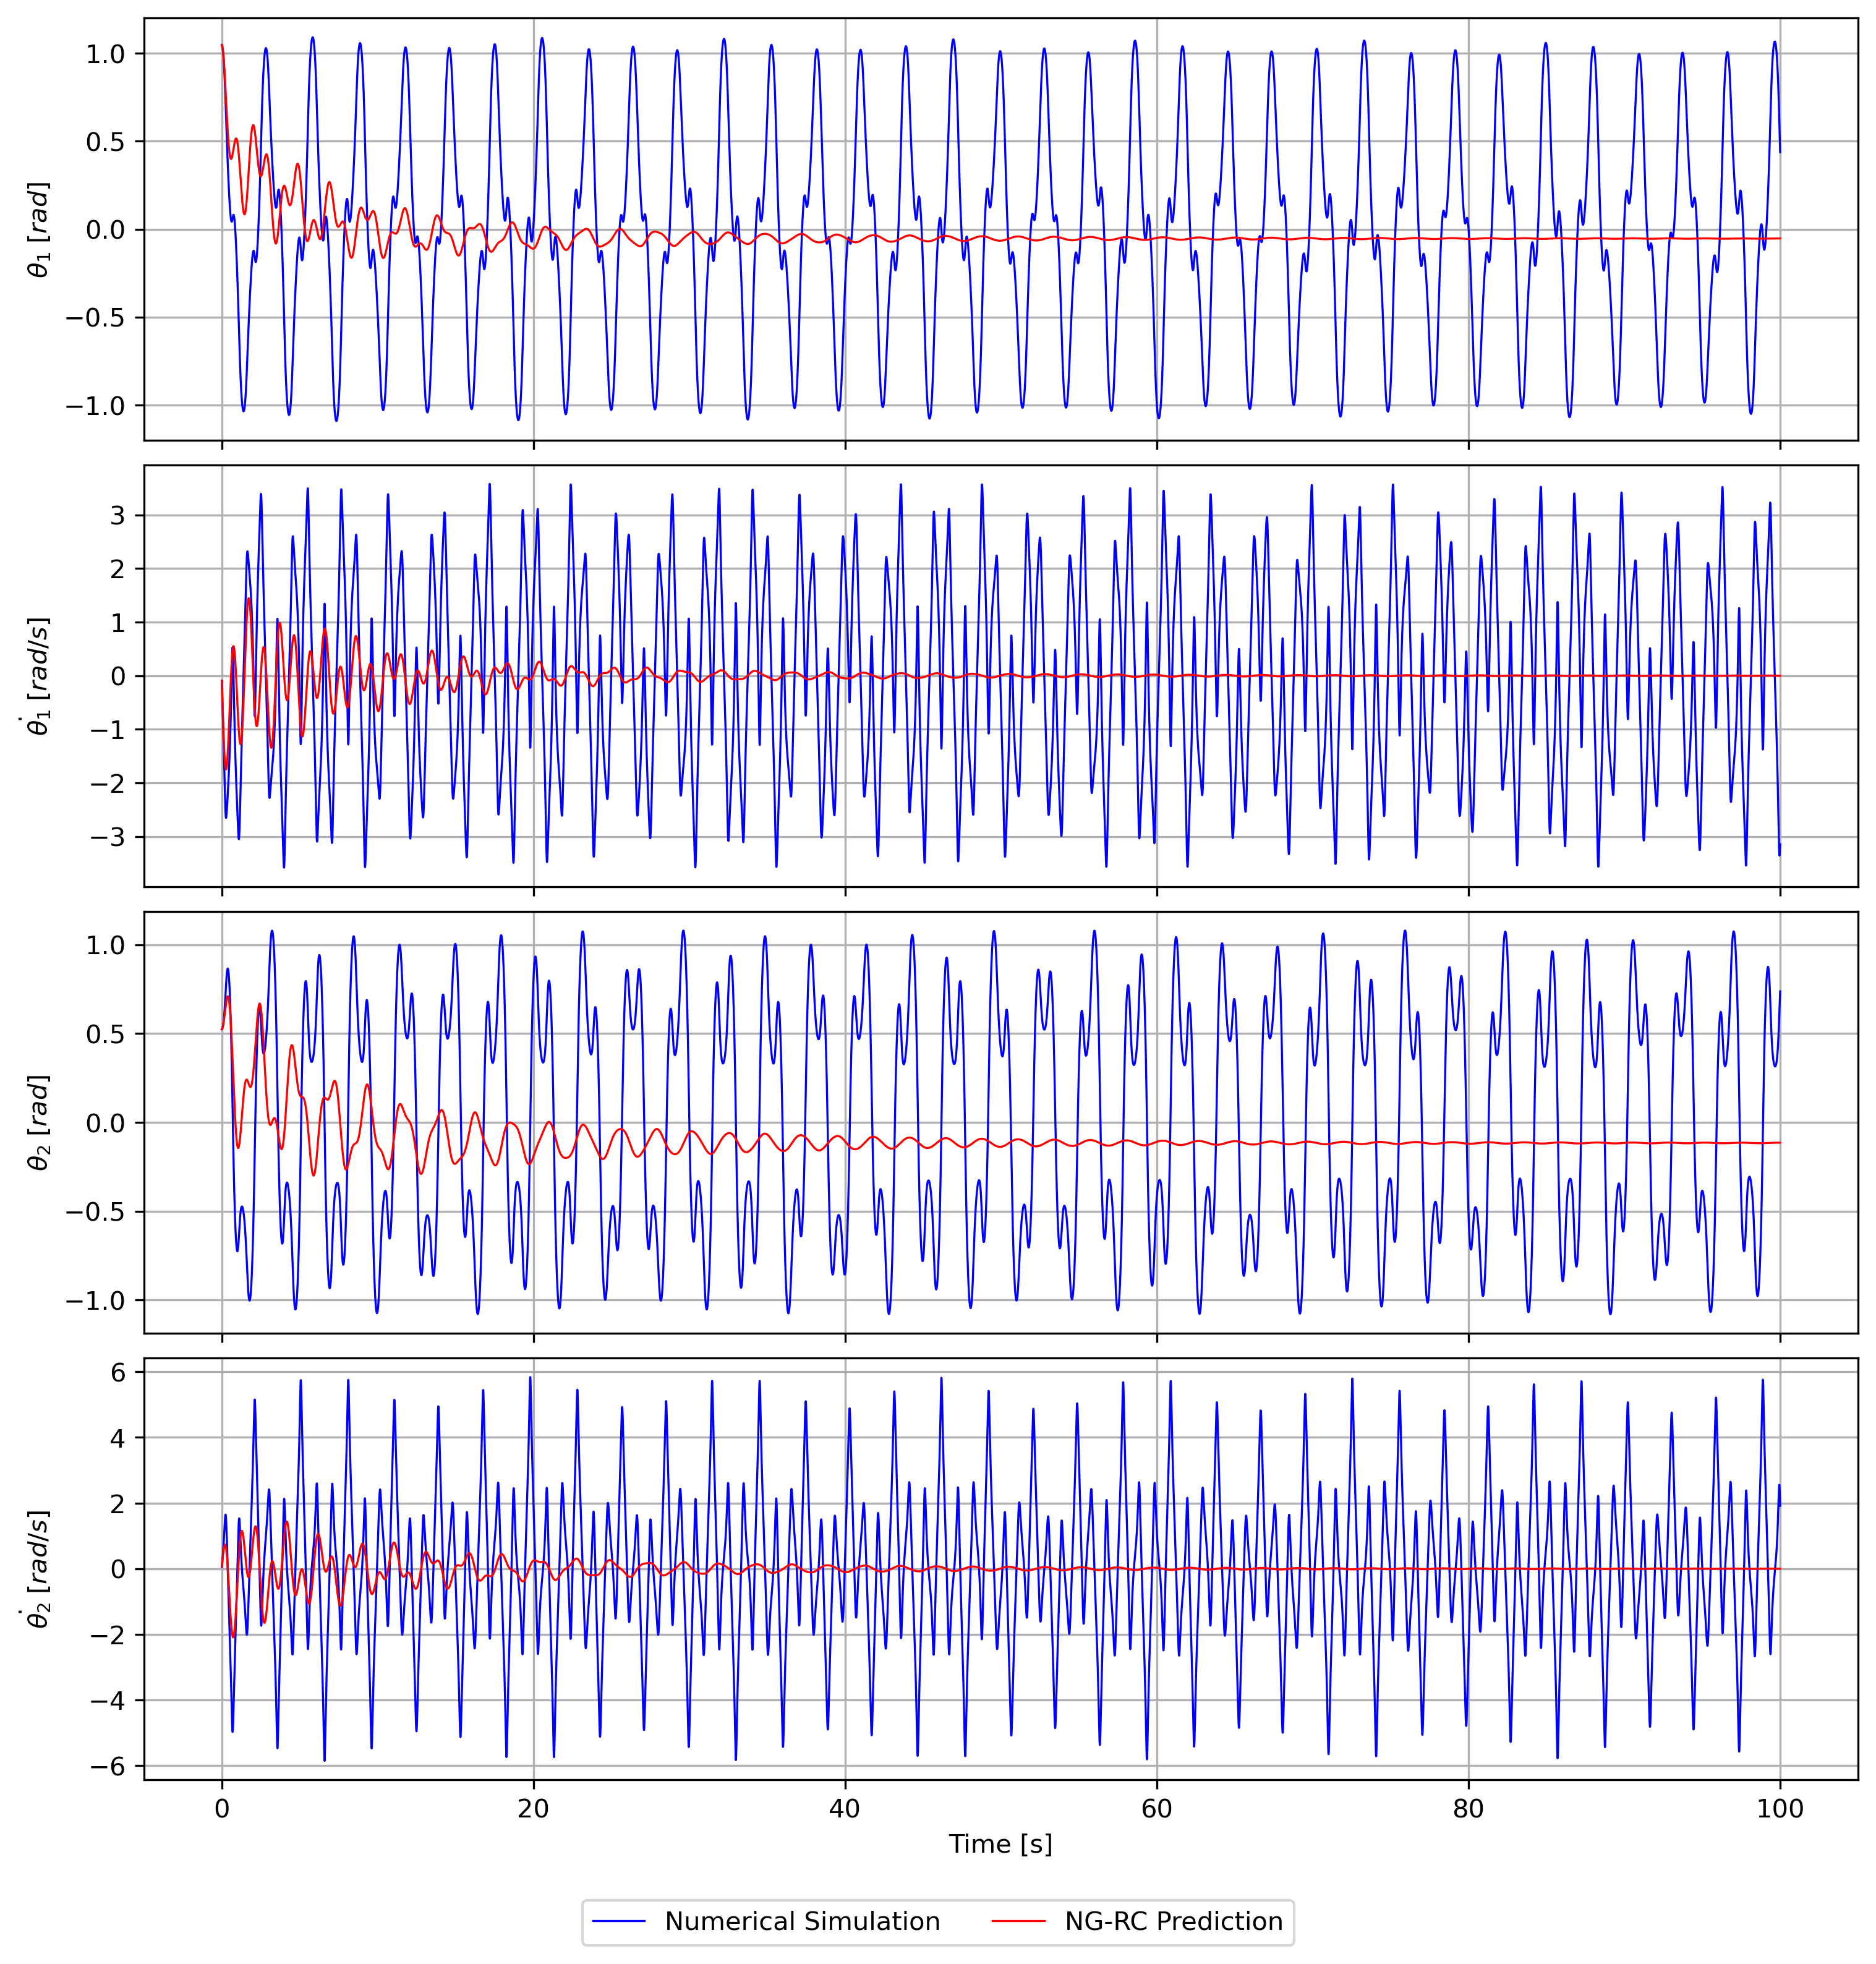

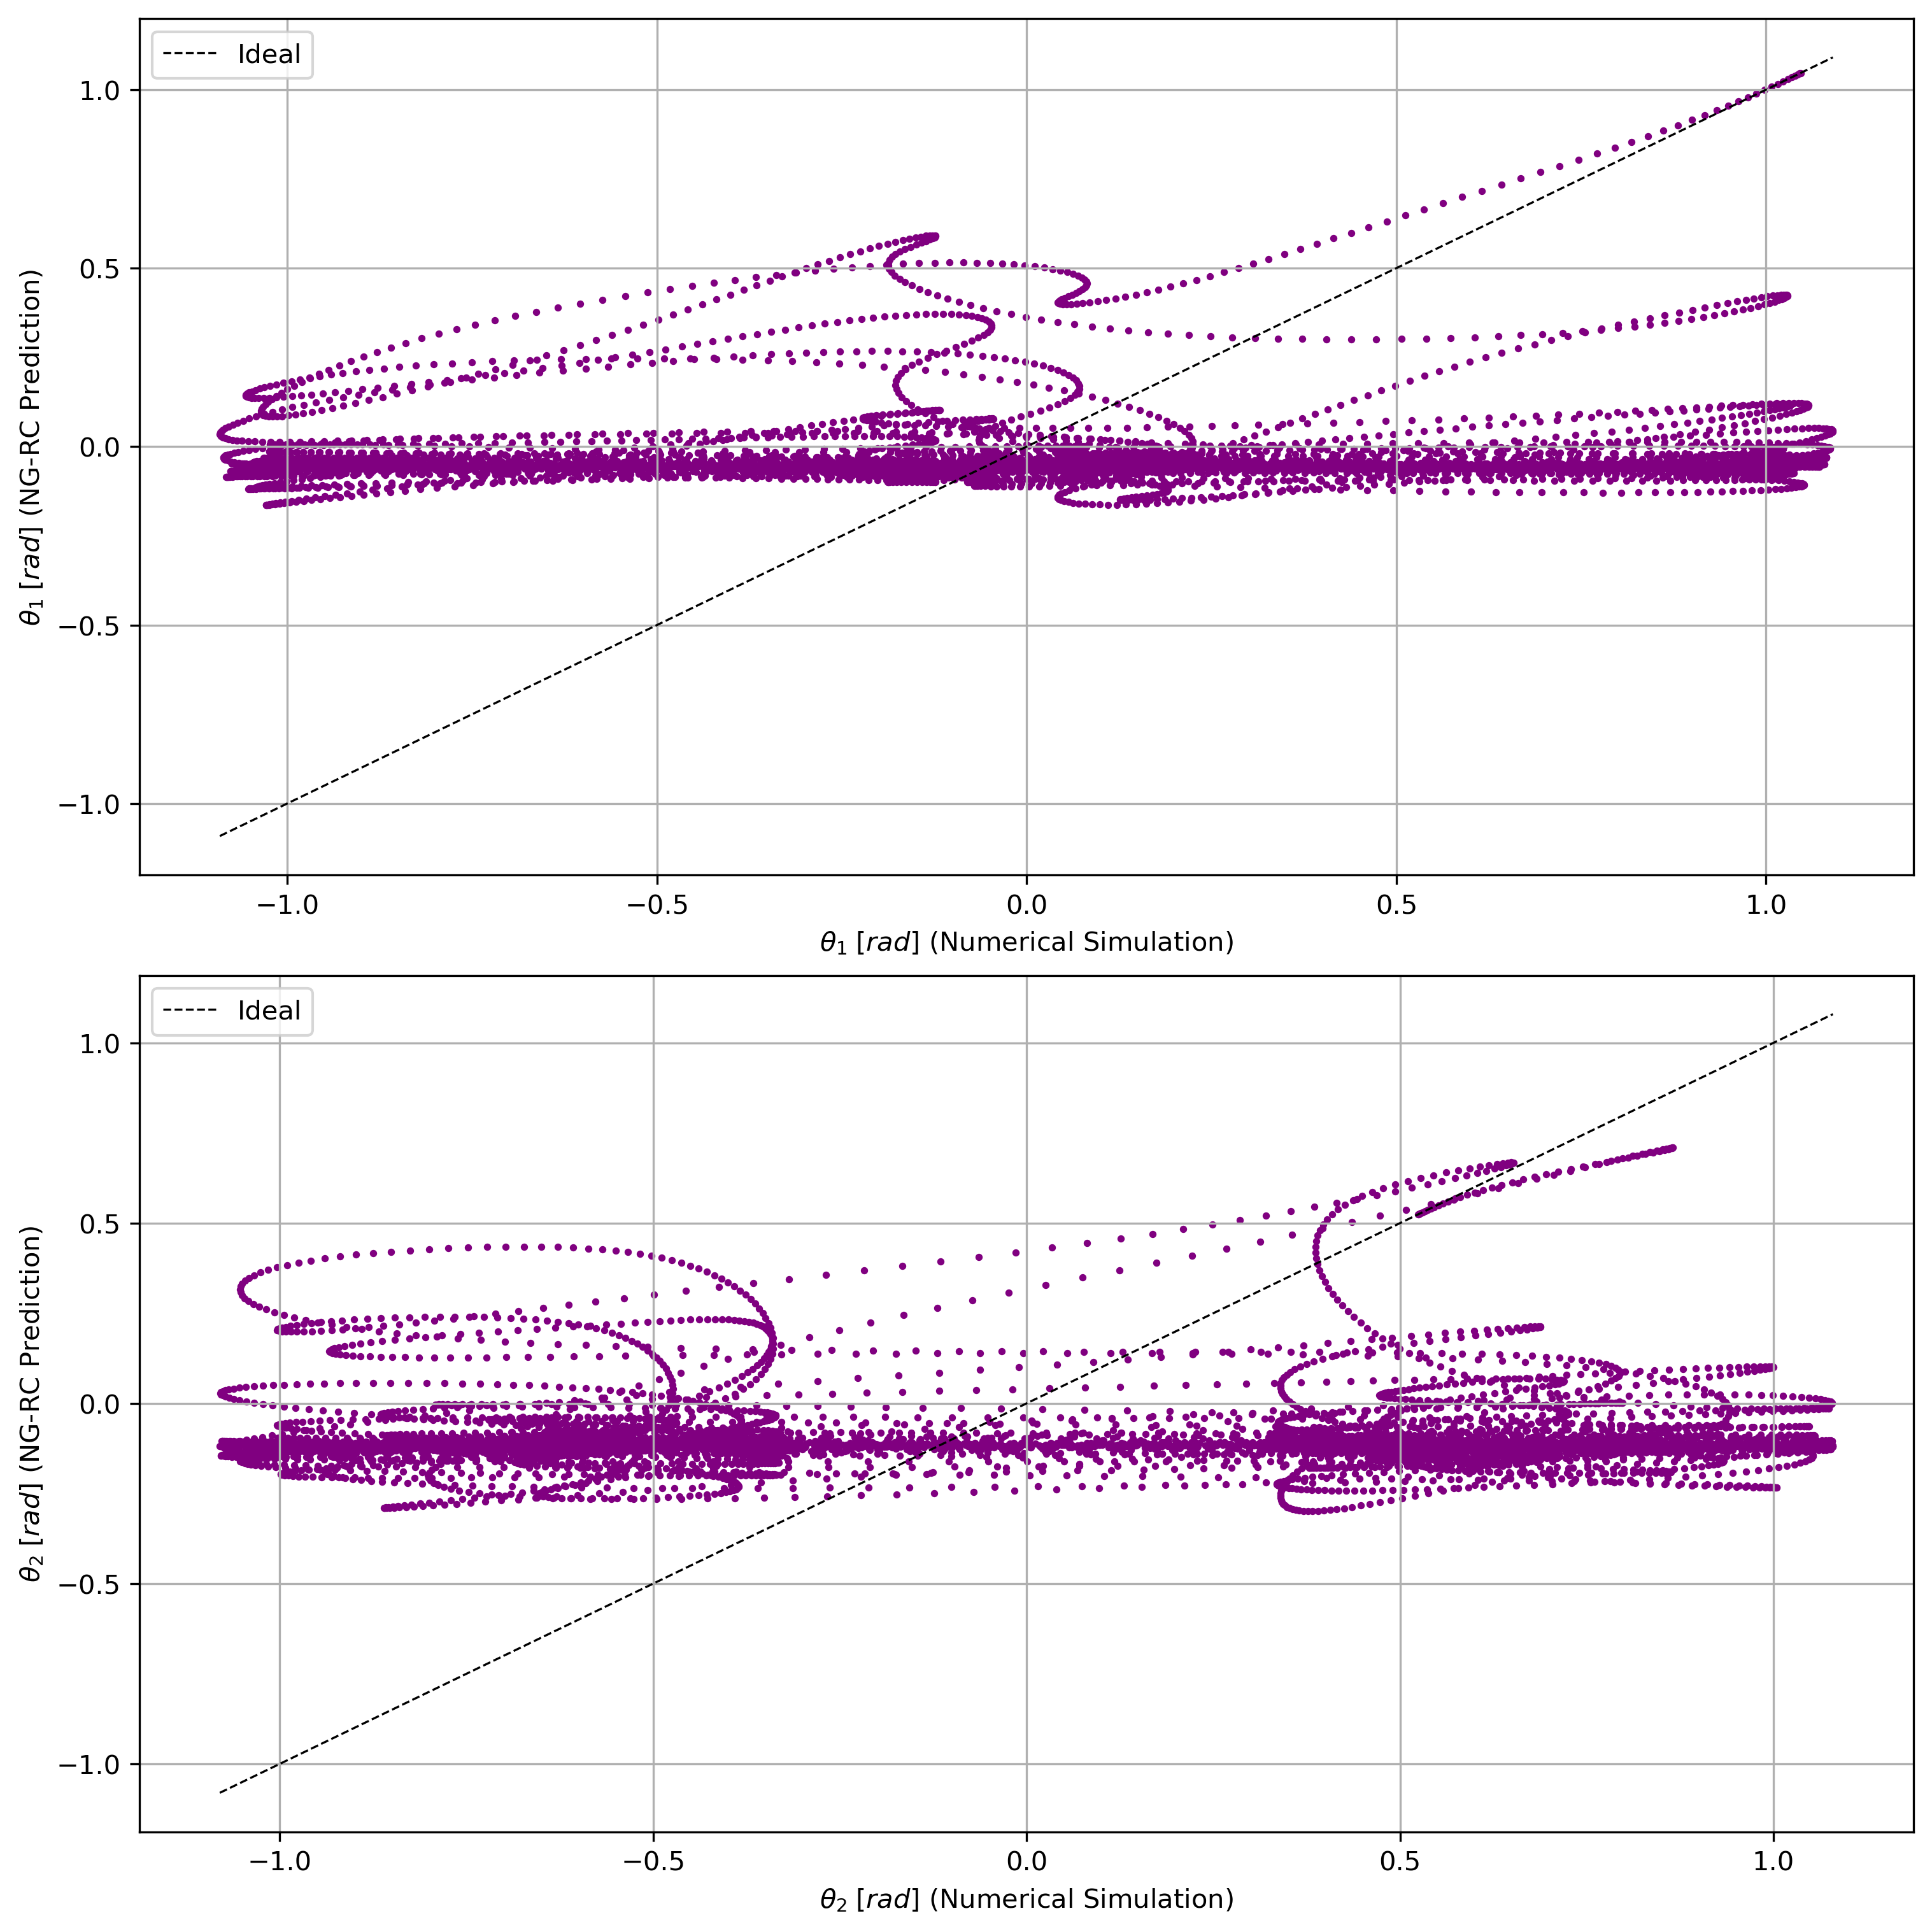

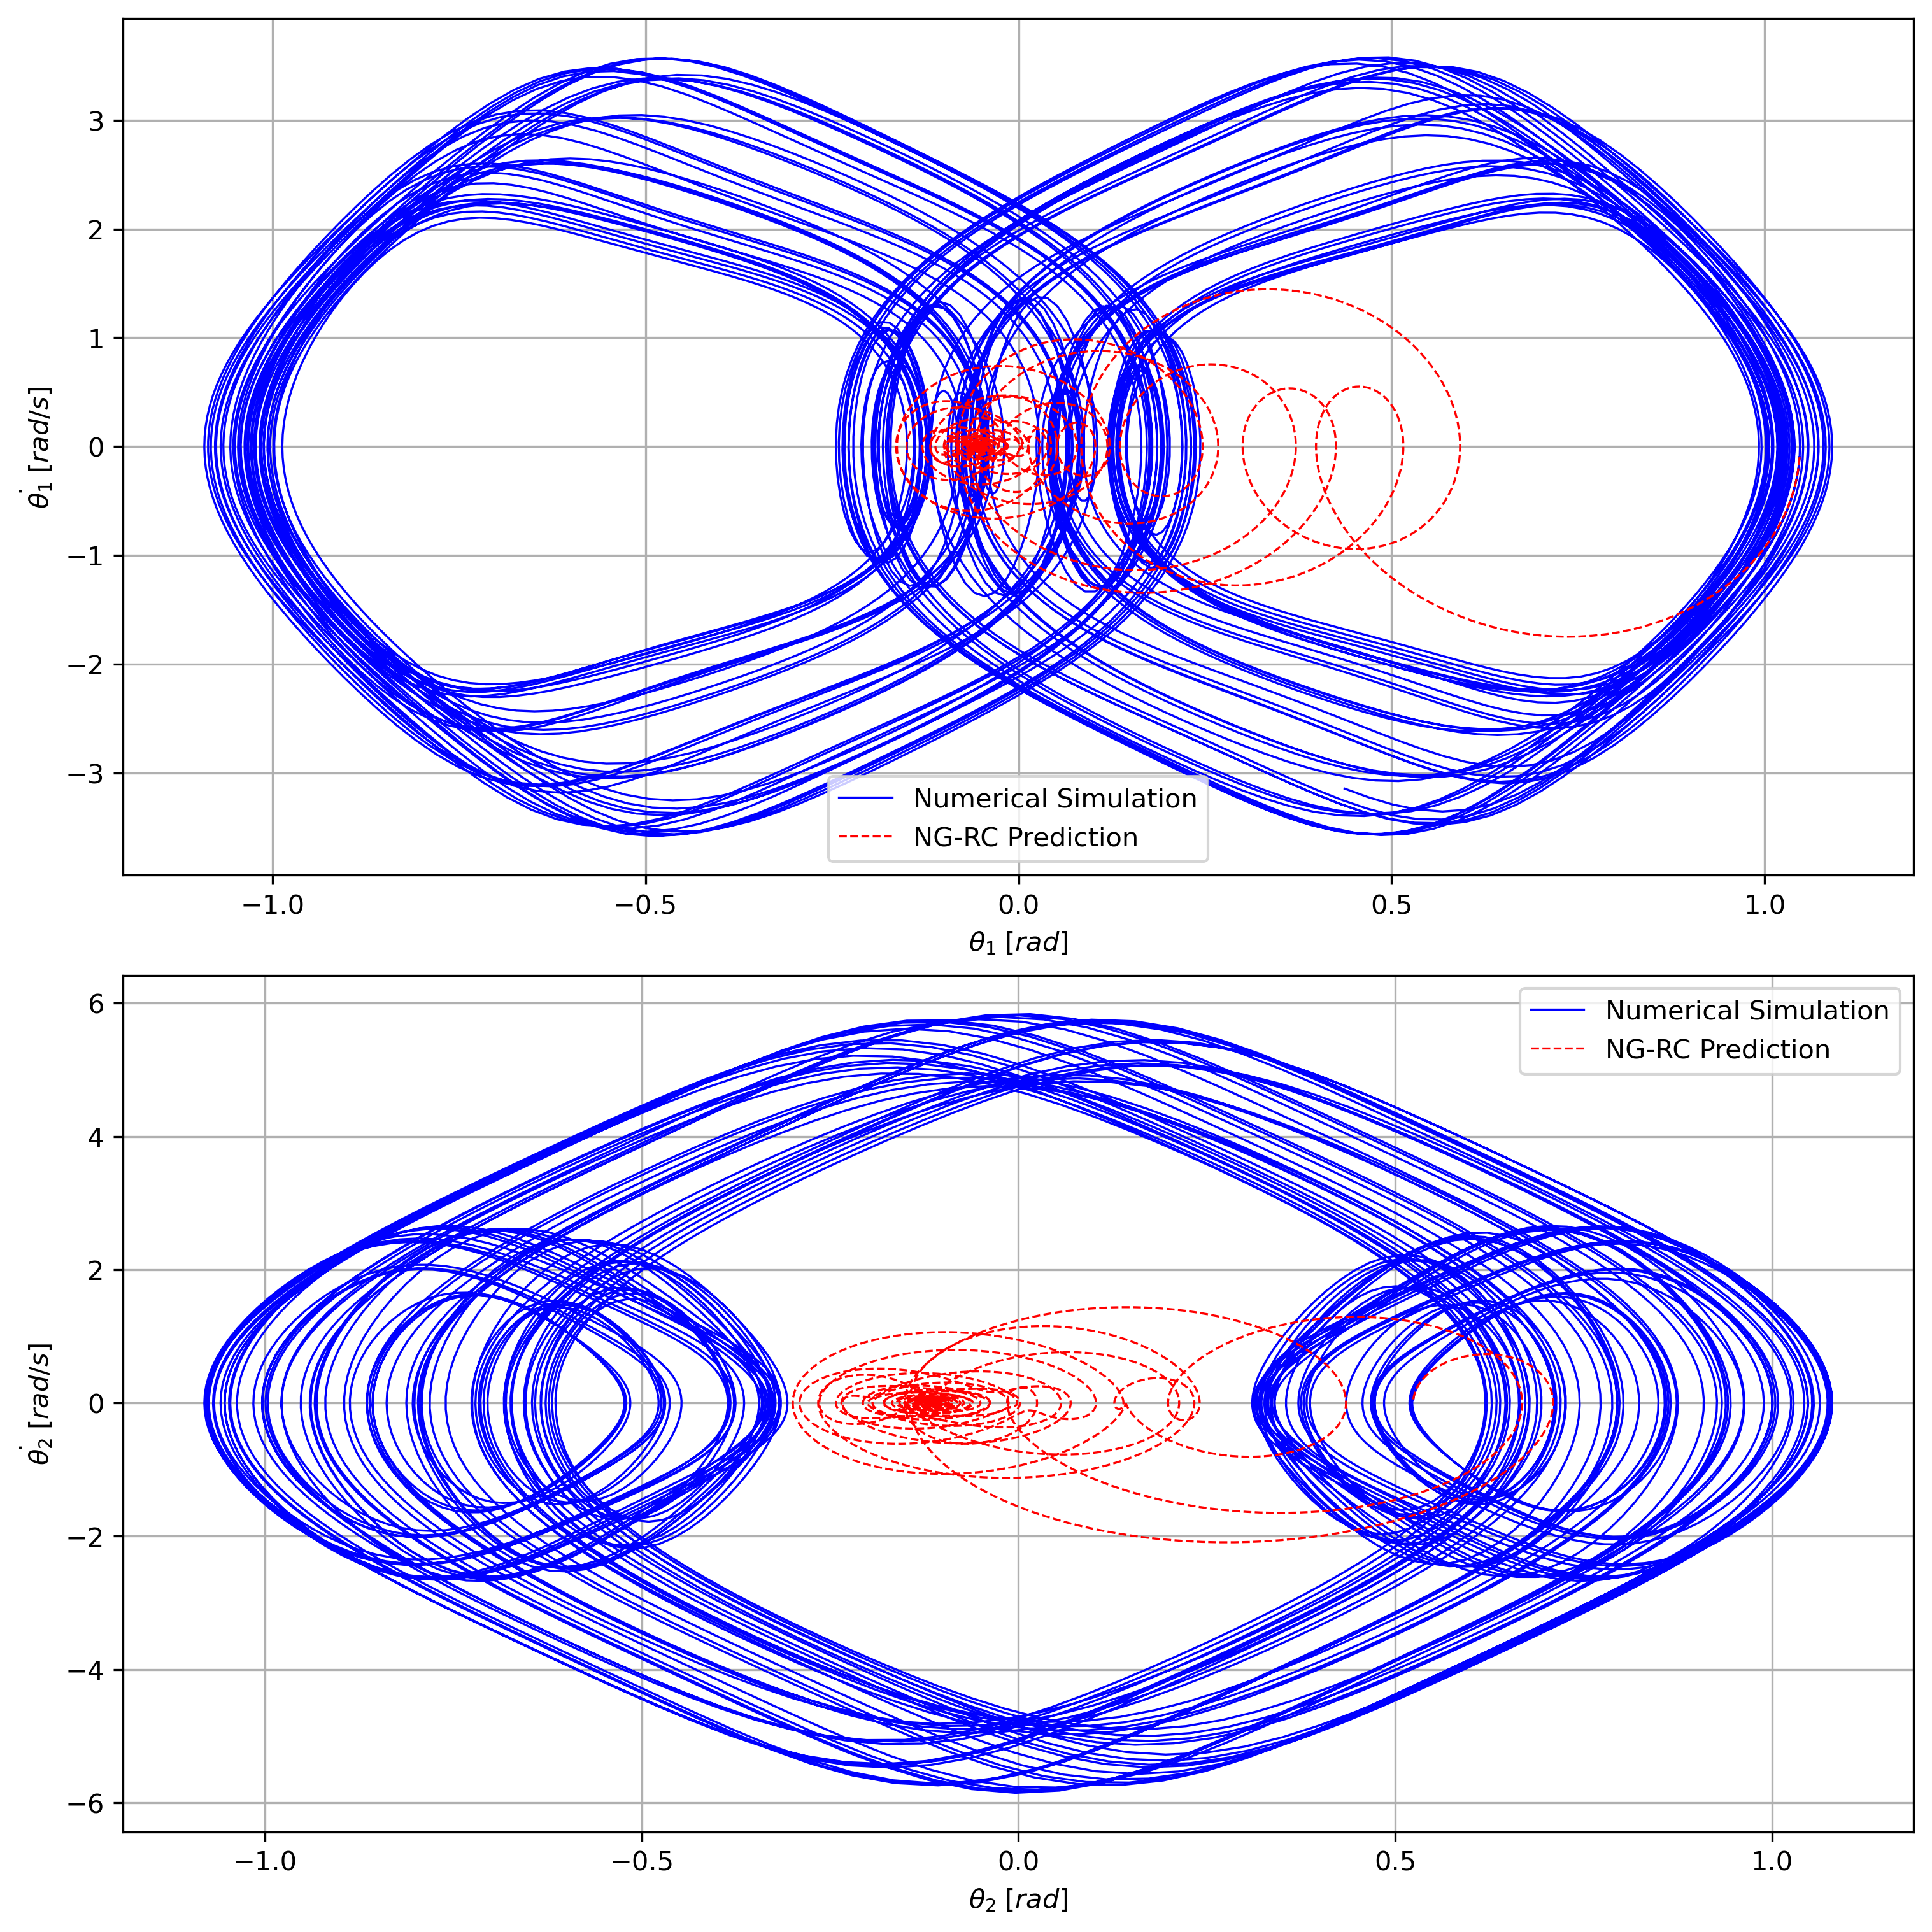

In [21]:

labels_full = [r"$\theta_1 \; [rad]$", r"$\dot{\theta_1} \; [rad/s]$", r"$\theta_2 \; [rad]$", r"$\dot{\theta_2} \; [rad/s]$"]

plot_comparison = plot_comparison_only_testing(y_true_test, y_pred_test, t_test, labels_full)

labels_scatter = [labels_full[0], labels_full[2]]
properties_scatter_idx = [0, 2]
plot_scatter_comparison = plot_scatter_comparison_only_testing(y_true_test, y_pred_test, properties_scatter_idx, labels_scatter)

labels_phase = [
    [labels_full[0], labels_full[1]], 
    [labels_full[2], labels_full[3]]
]
properties_phase_idx = [
    [0, 1], 
    [2, 3]
]
plot_phase_comparison = plot_phase_comparison_only_testing( y_true_test, y_pred_test, properties_phase_idx, labels_phase)

param_names = ["L1", "M1"]
var_names = ["\\theta_1", "\\dot\\theta_1", "\\theta_2", "\\dot\\theta_2"]
fig_wout = plot_W_out(W_out, model_params, feature_vec_obj, param_names, var_names)